In [1]:
pip install mnist==0.2.2

Note: you may need to restart the kernel to use updated packages.


In [2]:
import mnist
import numpy as np
# here only use the first 1k examples of each set in the interest of time.
# Feel free to change this if you want.
train_images_1 = mnist.train_images()[:1000]
train_labels_1 = mnist.train_labels()[:1000]
test_images_1 = mnist.test_images()[:1000]
test_labels_1 = mnist.test_labels()[:1000]

train_images = []
train_labels =[]
test_images =[]
test_labels = []
for i in range(1000):
  if train_labels_1[i]==1:
    train_images.append(train_images_1[i])
    train_labels.append(train_labels_1[i])
  if test_labels_1[i] == 1:
    test_images.append(test_images_1[i])
    test_labels.append(test_labels_1[i])
  if train_labels_1[i]==0:
    train_images.append(train_images_1[i])
    train_labels.append(train_labels_1[i])
  if test_labels_1[i] == 0:
    test_images.append(test_images_1[i])
    test_labels.append(test_labels_1[i])

train_images = np.asarray(train_images)
test_images = np.asarray(test_images)
train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)
print(train_images.shape, test_images.shape)
print("\n labels or classes", np.unique(train_labels))

(213, 28, 28) (211, 28, 28)

 labels or classes [0 1]


In [6]:
train_images.shape

(213, 28, 28)

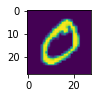

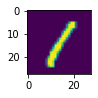

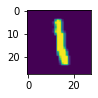

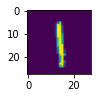

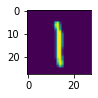

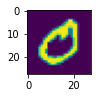

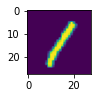

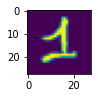

In [7]:
from matplotlib import pyplot
for i in range(8):  
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(train_images[i])
    pyplot.show()

In [39]:
import numpy as np

'''
Note: In this implementation, we assume the input is a 2d numpy array for simplicity, because that's
how our MNIST images are stored. This works for us because we use it as the first layer in our
network, but most CNNs have many more Conv layers. If we were building a bigger network that needed
to use Conv3x3 multiple times, we'd have to make the input be a 3d numpy array.
'''

class Conv3x3:
  # A Convolution layer using 3x3 filters.

  def __init__(self, num_filters):
    self.num_filters = num_filters

    # filters is a 3d array with dimensions (num_filters, 3, 3)
    # We divide by 9 to reduce the variance of our initial values
    self.filters = np.random.randn(num_filters, 3, 3) / 9

  def iterate_regions(self, image):
    '''
    Generates all possible 3x3 image regions using valid padding.
    - image is a 2d numpy array.
    '''
    h, w = image.shape

    for i in range(h - 2):
      for j in range(w - 2):
        im_region = image[i:(i + 3), j:(j + 3)]
        yield im_region, i, j

  def forward(self, input):
    '''
    Performs a forward pass of the conv layer using the given input.
    Returns a 3d numpy array with dimensions (h, w, num_filters).
    - input is a 2d numpy array
    '''
    self.last_input = input

    h, w = input.shape
    output = np.zeros((h - 2, w - 2, self.num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))

    return output

  def backprop(self, d_L_d_out, learn_rate):
    '''
    Performs a backward pass of the conv layer.
    - d_L_d_out is the loss gradient for this layer's outputs.
    - learn_rate is a float.
    '''
    d_L_d_filters = np.zeros(self.filters.shape)

    for im_region, i, j in self.iterate_regions(self.last_input):
      for f in range(self.num_filters):
        d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region

    # Update filters
    self.filters -= learn_rate * d_L_d_filters

    # We aren't returning anything here since we use Conv3x3 as the first layer in our CNN.
    # Otherwise, we'd need to return the loss gradient for this layer's inputs, just like every
    # other layer in our CNN.
    return None

In [40]:
import numpy as np

class MaxPool2:
  # A Max Pooling layer using a pool size of 2.

  def iterate_regions(self, image):
    '''
    Generates non-overlapping 2x2 image regions to pool over.
    - image is a 2d numpy array
    '''
    h, w, _ = image.shape
    new_h = h // 2
    new_w = w // 2

    for i in range(new_h):
      for j in range(new_w):
        im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
        yield im_region, i, j

  def forward(self, input):
    '''
    Performs a forward pass of the maxpool layer using the given input.
    Returns a 3d numpy array with dimensions (h / 2, w / 2, num_filters).
    - input is a 3d numpy array with dimensions (h, w, num_filters)
    '''
    self.last_input = input

    h, w, num_filters = input.shape
    output = np.zeros((h // 2, w // 2, num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.amax(im_region, axis=(0, 1))

    return output

  def backprop(self, d_L_d_out):
    '''
    Performs a backward pass of the maxpool layer.
    Returns the loss gradient for this layer's inputs.
    - d_L_d_out is the loss gradient for this layer's outputs.
    '''
    d_L_d_input = np.zeros(self.last_input.shape)

    for im_region, i, j in self.iterate_regions(self.last_input):
      h, w, f = im_region.shape
      amax = np.amax(im_region, axis=(0, 1))

      for i2 in range(h):
        for j2 in range(w):
          for f2 in range(f):
            # If this pixel was the max value, copy the gradient to it.
            if im_region[i2, j2, f2] == amax[f2]:
              d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

    return d_L_d_input

In [41]:
import numpy as np

class Softmax:
  # A standard fully-connected layer with softmax activation.

  def __init__(self, input_len, nodes):
    # We divide by input_len to reduce the variance of our initial values
    self.weights = np.random.randn(input_len, nodes) / input_len
    self.biases = np.zeros(nodes)

  def forward(self, input):
    '''
    Performs a forward pass of the softmax layer using the given input.
    Returns a 1d numpy array containing the respective probability values.
    - input can be any array with any dimensions.
    '''
    self.last_input_shape = input.shape

    input = input.flatten()
    self.last_input = input

    input_len, nodes = self.weights.shape

    totals = np.dot(input, self.weights) + self.biases
    self.last_totals = totals

    exp = np.exp(totals)
    return exp / np.sum(exp, axis=0)

  def backprop(self, d_L_d_out, learn_rate):
    '''
    Performs a backward pass of the softmax layer.
    Returns the loss gradient for this layer's inputs.
    - d_L_d_out is the loss gradient for this layer's outputs.
    - learn_rate is a float.
    '''
    # We know only 1 element of d_L_d_out will be nonzero
    for i, gradient in enumerate(d_L_d_out):
      if gradient == 0:
        continue

      # e^totals
      t_exp = np.exp(self.last_totals)

      # Sum of all e^totals
      S = np.sum(t_exp)

      # Gradients of out[i] against totals
      d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
      d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

      # Gradients of totals against weights/biases/input
      d_t_d_w = self.last_input
      d_t_d_b = 1
      d_t_d_inputs = self.weights

      # Gradients of loss against totals
      d_L_d_t = gradient * d_out_d_t

      # Gradients of loss against weights/biases/input
      d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
      d_L_d_b = d_L_d_t * d_t_d_b
      d_L_d_inputs = d_t_d_inputs @ d_L_d_t

      # Update weights / biases
      self.weights -= learn_rate * d_L_d_w
      self.biases -= learn_rate * d_L_d_b

      return d_L_d_inputs.reshape(self.last_input_shape)

In [59]:
conv = Conv3x3(8)                  # 28x28x1 -> 26x26x8
pool = MaxPool2()                  # 26x26x8 -> 13x13x8
softmax = Softmax(13 * 13 * 8, 2) # 13x13x8 -> 10

def forward(image, label):
  '''
  Completes a forward pass of the CNN and calculates the accuracy and
  cross-entropy loss.
  - image is a 2d numpy array
  - label is a digit
  '''
  # We transform the image from [0, 255] to [-0.5, 0.5] to make it easier
  # to work with. This is standard practice.
  out = conv.forward((image / 255) - 0.5)
  out = pool.forward(out)
  out = softmax.forward(out)

  # Calculate cross-entropy loss and accuracy. np.log() is the natural log.
  loss = -np.log(out[label])
  acc = 1 if np.argmax(out) == label else 0

  return out, loss, acc

def train(im, label, lr=.005):
  '''
  Completes a full training step on the given image and label.
  Returns the cross-entropy loss and accuracy.
  - image is a 2d numpy array
  - label is a digit
  - lr is the learning rate
  '''
  # Forward
  out, loss, acc = forward(im, label)

  # Calculate initial gradient
  gradient = np.zeros(2)
  gradient[label] = -1 / out[label]

  # Backprop
  gradient = softmax.backprop(gradient, lr)
  gradient = pool.backprop(gradient)
  gradient = conv.backprop(gradient, lr)

  return loss, acc

print('MNIST CNN initialized!')

# Train the CNN for 3 epochs
for epoch in range(3):
  print('--- Epoch %d ---' % (epoch + 1))

  # Shuffle the training data
  permutation = np.random.permutation(len(train_images))
  train_images = train_images[permutation]
  train_labels = train_labels[permutation]

  # Train!
  loss = 0
  num_correct = 0
  for i, (im, label) in enumerate(zip(train_images, train_labels)):
    if i % 100 == 99:
      print(
        '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
        (i + 1, loss / 100, num_correct)
      )
      loss = 0
      num_correct = 0

    l, acc = train(im, label)
    loss += l
    num_correct += acc

# Test the CNN
print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0
output =[]
for im, label in zip(test_images, test_labels):
  out, l, acc = forward(im, label)
  loss += l
  output.append(np.argmax(out))
  num_correct += acc

num_tests = len(test_images)
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)

MNIST CNN initialized!
--- Epoch 1 ---
[Step 100] Past 100 steps: Average Loss 0.391 | Accuracy: 85%
[Step 200] Past 100 steps: Average Loss 0.087 | Accuracy: 100%
--- Epoch 2 ---
[Step 100] Past 100 steps: Average Loss 0.029 | Accuracy: 99%
[Step 200] Past 100 steps: Average Loss 0.029 | Accuracy: 99%
--- Epoch 3 ---
[Step 100] Past 100 steps: Average Loss 0.012 | Accuracy: 99%
[Step 200] Past 100 steps: Average Loss 0.023 | Accuracy: 98%

--- Testing the CNN ---
Test Loss: 0.013794284853140772
Test Accuracy: 0.995260663507109


In [60]:
print("Original 5 test labels \n", test_labels[:5] )
print("\n Predicted 5 test labels \n", (np.asarray(output))[:5])

Original 5 test labels 
 [1 0 1 0 0]

 Predicted 5 test labels 
 [1 0 1 0 0]


In [45]:
# with number of filters reduced to 3

conv = Conv3x3(3)                  # 28x28x1 -> 26x26x3
pool = MaxPool2()                  # 26x26x8 -> 13x13x3
softmax = Softmax(13 * 13 * 3, 2) # 13x13x8 -> 2

def forward(image, label):
  '''
  Completes a forward pass of the CNN and calculates the accuracy and
  cross-entropy loss.
  - image is a 2d numpy array
  - label is a digit
  '''
  # We transform the image from [0, 255] to [-0.5, 0.5] to make it easier
  # to work with. This is standard practice.
  out = conv.forward((image / 255) - 0.5)
  out_pool = pool.forward(out)
  out_fcc = softmax.forward(out_pool)

  # Calculate cross-entropy loss and accuracy. np.log() is the natural log.
  loss = -np.log(out_fcc[label])
  acc = 1 if np.argmax(out_fcc) == label else 0

  return out,out_pool,out_fcc, loss, acc

def train(im, label, lr=.005):
  '''
  Completes a full training step on the given image and label.
  Returns the cross-entropy loss and accuracy.
  - image is a 2d numpy array
  - label is a digit
  - lr is the learning rate
  '''
  # Forward
  out,out_pool,out_fcc, loss, acc = forward(im, label)

  # Calculate initial gradient
  gradient = np.zeros(10)
  gradient[label] = -1 / out_fcc[label]

  # Backprop
  gradient = softmax.backprop(gradient, lr)
  gradient = pool.backprop(gradient)
  gradient = conv.backprop(gradient, lr)

  return loss, acc, out, out_pool, out_fcc

print('MNIST CNN initialized!')

# Train the CNN for 3 epochs
for epoch in range(3):
  print('--- Epoch %d ---' % (epoch + 1))

  # Shuffle the training data
  permutation = np.random.permutation(len(train_images))
  train_images = train_images[permutation]
  train_labels = train_labels[permutation]

  # Train!
  loss = 0
  num_correct = 0
  for i, (im, label) in enumerate(zip(train_images, train_labels)):
    if i % 100 == 99:
      print(
        '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
        (i + 1, loss / 100, num_correct)
      )
      loss = 0
      num_correct = 0

    l, acc, out, out_pool, out_fcc = train(im, label)
    loss += l
    num_correct += acc

# Test the CNN
print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0
for im, label in zip(test_images, test_labels):
  out, out_pool, out_fcc, l, acc = forward(im, label)
  loss += l
  num_correct += acc

num_tests = len(test_images)
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)

MNIST CNN initialized!
--- Epoch 1 ---
[Step 100] Past 100 steps: Average Loss 0.460 | Accuracy: 86%
[Step 200] Past 100 steps: Average Loss 0.073 | Accuracy: 98%
--- Epoch 2 ---
[Step 100] Past 100 steps: Average Loss 0.022 | Accuracy: 99%
[Step 200] Past 100 steps: Average Loss 0.034 | Accuracy: 100%
--- Epoch 3 ---
[Step 100] Past 100 steps: Average Loss 0.006 | Accuracy: 99%
[Step 200] Past 100 steps: Average Loss 0.021 | Accuracy: 100%

--- Testing the CNN ---
Test Loss: 0.010996657530478602
Test Accuracy: 1.0


**Layerwise Outputs**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output of Convolutional layer
Shape (26, 26, 3)


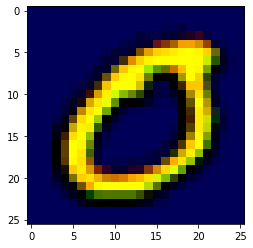

In [48]:
print("Output of Convolutional layer")
print("Shape", out.shape)
plt.imshow(out)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(13, 13, 3)


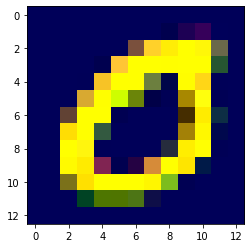

In [49]:
import matplotlib.pyplot as plt
print(out_pool.shape)
plt.imshow(out_pool)

original image


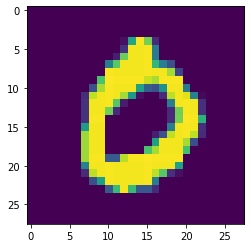

In [50]:
print("original image")
plt.imshow(test_images[1])

In [ ]:
import matplotlib.pyplot as plt
im = test_images[1]
o = conv.forward((im / 255) - 0.5)
op = pool.forward(o)
os = softmax.forward(op)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


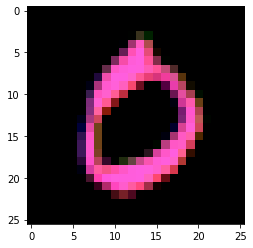

In [ ]:
plt.imshow(o)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


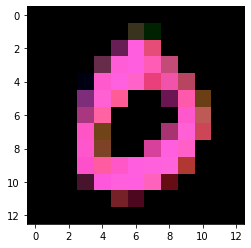

In [ ]:
plt.imshow(op)

# **Translational Invariance**

In [ ]:
import tensorflow as tf

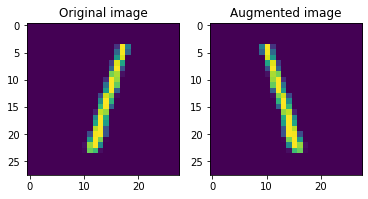

In [30]:

image= test_images[0].reshape(28,28,1)
label = test_labels[0]
def visualize(original, augmented):
    fig = pyplot.figure()
    pyplot.subplot(1,2,1)
    pyplot.title('Original image')
    pyplot.imshow(original)

    pyplot.subplot(1,2,2)
    pyplot.title('Augmented image')
    pyplot.imshow(augmented)

flipped = tf.image.flip_left_right(image)
flipped=  np.array(flipped)
image=image.reshape(28,28)
flipped=flipped.reshape(28,28)
visualize(image, flipped)

In [34]:
out, out_pool, out_fcc, l, acc = forward(image, label)
print("loss for original image:", l, "\n accuracy for original image:",acc, "\npredicted output for original: ", np.argmax(out_fcc))
out, out_pool, out_fcc, l, acc = forward(flipped, label)
print("\n loss for augmented image:", l, "\n accuracy for augmented image:",acc, "\npredicted output for augmented: ", np.argmax(out_fcc))

loss for original image: 0.0020418647488202302 
 accuracy for original image: 1 
predicted output for original:  1

 loss for augmented image: 0.014636098706283797 
 accuracy for augmented image: 1 
predicted output for augmented:  1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


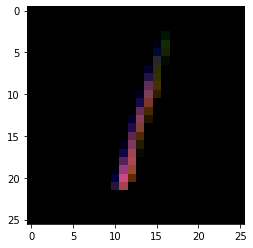

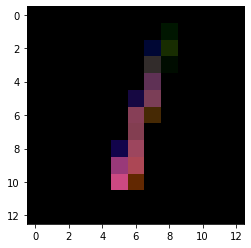

In [25]:
o = conv.forward((image / 255) - 0.5)
op = pool.forward(o)
os = softmax.forward(op)
plt.figure()
plt.imshow(o)
plt.figure()
plt.imshow(op)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


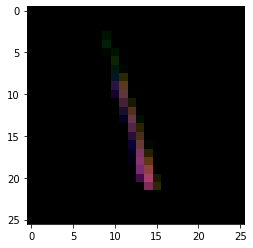

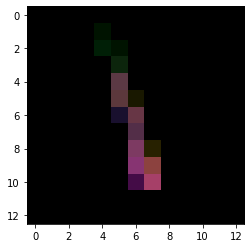

In [26]:
o = conv.forward((flipped / 255) - 0.5)
op = pool.forward(o)
os = softmax.forward(op)
plt.figure()
plt.imshow(o)
plt.figure()
plt.imshow(op)

In [51]:
# shifted data training
shiftedXTrain = np.concatenate((train_images[:,:,2:],np.zeros((train_images.shape[0],28,2))) , axis = 2)
shiftedYTrain = train_labels

shiftedXTest = np.concatenate((test_images[:,:,2:],np.zeros((test_images.shape[0],28,2))) , axis = 2)
shiftedYTest = test_labels
print(shiftedXTrain.shape)

(213, 28, 28)


(28, 28)
(28, 28)


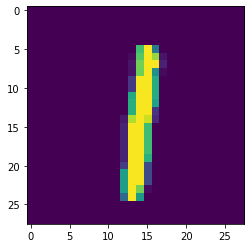

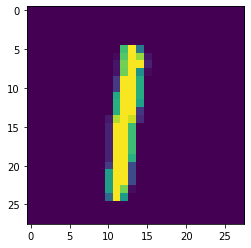

In [54]:
print(train_images[1].shape)
plt.imshow(train_images[1])
plt.figure()
print(shiftedXTrain[1].shape)
plt.imshow(shiftedXTrain[1])

**Translational invariance by training through shifted train and test data**

In [61]:
# with number of filters reduced to 3

conv = Conv3x3(3)                  # 28x28x1 -> 26x26x3
pool = MaxPool2()                  # 26x26x8 -> 13x13x3
softmax = Softmax(13 * 13 * 3, 2) # 13x13x8 -> 2

def forward(image, label):
  '''
  Completes a forward pass of the CNN and calculates the accuracy and
  cross-entropy loss.
  - image is a 2d numpy array
  - label is a digit
  '''
  # We transform the image from [0, 255] to [-0.5, 0.5] to make it easier
  # to work with. This is standard practice.
  out = conv.forward((image / 255) - 0.5)
  out_pool = pool.forward(out)
  out_fcc = softmax.forward(out_pool)

  # Calculate cross-entropy loss and accuracy. np.log() is the natural log.
  loss = -np.log(out_fcc[label])
  acc = 1 if np.argmax(out_fcc) == label else 0

  return out,out_pool,out_fcc, loss, acc

def train(im, label, lr=.005):
  '''
  Completes a full training step on the given image and label.
  Returns the cross-entropy loss and accuracy.
  - image is a 2d numpy array
  - label is a digit
  - lr is the learning rate
  '''
  # Forward
  out,out_pool,out_fcc, loss, acc = forward(im, label)

  # Calculate initial gradient
  gradient = np.zeros(10)
  gradient[label] = -1 / out_fcc[label]

  # Backprop
  gradient = softmax.backprop(gradient, lr)
  gradient = pool.backprop(gradient)
  gradient = conv.backprop(gradient, lr)

  return loss, acc, out, out_pool, out_fcc

print('MNIST CNN initialized!')

# Train the CNN for 3 epochs
for epoch in range(3):
  print('--- Epoch %d ---' % (epoch + 1))

  # Shuffle the training data
  permutation = np.random.permutation(len(shiftedXTrain))
  train_images = train_images[permutation]
  train_labels = train_labels[permutation]

  # Train!
  loss = 0
  num_correct = 0
  for i, (im, label) in enumerate(zip(shiftedXTrain, shiftedYTrain)):
    if i % 100 == 99:
      print(
        '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
        (i + 1, loss / 100, num_correct)
      )
      loss = 0
      num_correct = 0

    l, acc, out, out_pool, out_fcc = train(im, label)
    loss += l
    num_correct += acc

# Test the CNN
print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0
output = []
for im, label in zip(shiftedXTest, shiftedYTest):
  out, out_pool, out_fcc, l, acc = forward(im, label)
  loss += l
  output.append(np.argmax(out_fcc))
  num_correct += acc

num_tests = len(shiftedYTest)
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)

MNIST CNN initialized!
--- Epoch 1 ---
[Step 100] Past 100 steps: Average Loss 0.507 | Accuracy: 79%
[Step 200] Past 100 steps: Average Loss 0.105 | Accuracy: 98%
--- Epoch 2 ---
[Step 100] Past 100 steps: Average Loss 0.018 | Accuracy: 99%
[Step 200] Past 100 steps: Average Loss 0.034 | Accuracy: 99%
--- Epoch 3 ---
[Step 100] Past 100 steps: Average Loss 0.006 | Accuracy: 99%
[Step 200] Past 100 steps: Average Loss 0.021 | Accuracy: 99%

--- Testing the CNN ---
Test Loss: 0.010652602357751274
Test Accuracy: 1.0


In [62]:
print("Original 5 test labels \n", shiftedYTest[:5] )
print("\n Predicted 5 test labels \n", (np.asarray(output))[:5])

Original 5 test labels 
 [1 0 1 0 0]

 Predicted 5 test labels 
 [1 0 1 0 0]
